# Visualization of Gen and Reco

This notebook provides the visualization example of plotting the reconstructed PF candidates and generator-level truth particles, using the Nano inputs.

The google doc used to track the process is linked here: https://docs.google.com/document/d/1WBA_Li6HA_rLkwtkyaK2PNVq6lLVkvp3nAOfW5tsW7g/edit

- The names of reconstructed PF Candidate features start with `PF`, such as `PF_pt`, `PF_eta`, `PF_phi`;
- The names of generator-level truth particle features start with `packedGenPart`, such as `packedGenPart_pt`, `packedGenPart_eta`, `packedGenPart_phi`, `packedGenPart_mass`, `packedGenPart_charge`, `packedGenPart_pdgId`;


In [1]:
import uproot
import awkward as ak
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np

Basic code to display the HCAL segmentation (might not be super important here)

In [2]:
class HCALSegmentation(object):
    """
    document the hcal segment information
    numbers taken from http://cds.cern.ch/record/896897/files/note05_016.pdf
    """
    def __init__(self):
        self.etaPosSeg = [
                            0.087, 0.174, 0.261, 0.348, 0.435, 0.522, 0.609,
                            0.696, 0.783, 0.870, 0.957, 1.044, 1.131, 1.218,
                            1.305, 1.392, 1.479, 1.566, 1.653, 1.740, 1.830,
                            1.930, 2.043, 2.172, 2.322, 2.500, 2.650, 2.868,
                            3.00001
                          ]
        self.etaSeg = [ 0. ]
        for eta in self.etaPosSeg:
            self.etaSeg.insert(0, -eta)
            self.etaSeg.append(eta)
            
        # below this etaCut, the phi is 5 degrees per cell.
        # above it the phi segmentation is 10 degrees
        self.etaCut = 1.740
        self.nPhiHB = 72
        self.nPhiHE = 36
        
        self.phiPosSegHB = np.arange(-np.pi, np.pi, 2*np.pi/self.nPhiHB)
        self.phiPosSegHE = np.arange(-np.pi, np.pi, 2*np.pi/self.nPhiHE)

def make_line_collection():
    lines = []
    hcal = HCALSegmentation()
    for ieta in range(len(hcal.etaSeg)-1):
        eta = hcal.etaSeg[ieta]
        nPhi = hcal.nPhiHB if abs(eta)<hcal.etaCut else hcal.nPhiHE
        for iphi in range(nPhi):
            lines.append(((iphi*2*np.pi/nPhi-np.pi,hcal.etaSeg[ieta]),((iphi+1)*2*np.pi/nPhi-np.pi, hcal.etaSeg[ieta]  )))
            lines.append(((iphi*2*np.pi/nPhi-np.pi,hcal.etaSeg[ieta]),(iphi*2*np.pi/nPhi-np.pi,     hcal.etaSeg[ieta+1])))
                        
    ln_coll=matplotlib.collections.LineCollection(lines,linestyle='--',linewidth=0.05,colors=['grey',])
    
    return ln_coll

In [3]:
# read the ttree
tree = uproot.open("myNanoProdMc2016_NANO_1.root")["Events"]
# read the pf candidates and gen particle information into akward arrays
pfcands = tree.arrays(tree.keys('PF_*') + ['nPF'], entry_start=0, entry_stop=1000)
genparts = tree.arrays(tree.keys('packedGenPart_*') + ['npackedGenPart'], entry_start=0, entry_stop=1000)

Apply selections on the particle types for pf candidates based on the charge and pdgId

In [4]:
# charged particles
ispfChg  = pfcands['PF_charge']!=0
# neutral particles
ispfNeu  = pfcands['PF_charge']==0
# photons
ispfPho  = pfcands['PF_pdgId']==22
# neutral hadrons
ispfNeuH = pfcands['PF_pdgId']==130
# hf candidates
ispfHF   = (pfcands['PF_pdgId']==1) | (pfcands['PF_pdgId']==2)

Apply selections on the particle types for gen particles based on the charge and pdgId

In [5]:
# charged particles
isgenChg  = ((genparts['packedGenPart_charge']!=0) & (abs(genparts['packedGenPart_eta'])<2.5))
# neutral particles
isgenNeu  = (~isgenChg)
# photons
isgenPho  = (genparts['packedGenPart_pdgId']==22) & (abs(genparts['packedGenPart_eta'])<3.0)
# neutral hadrons
isgenNeuH = ((genparts['packedGenPart_charge']==0) & (genparts['packedGenPart_pdgId']!=22) & (abs(genparts['packedGenPart_eta'])<3.0))
# hf candidates
isgenHF   = (abs(genparts['packedGenPart_eta'])>3.0)

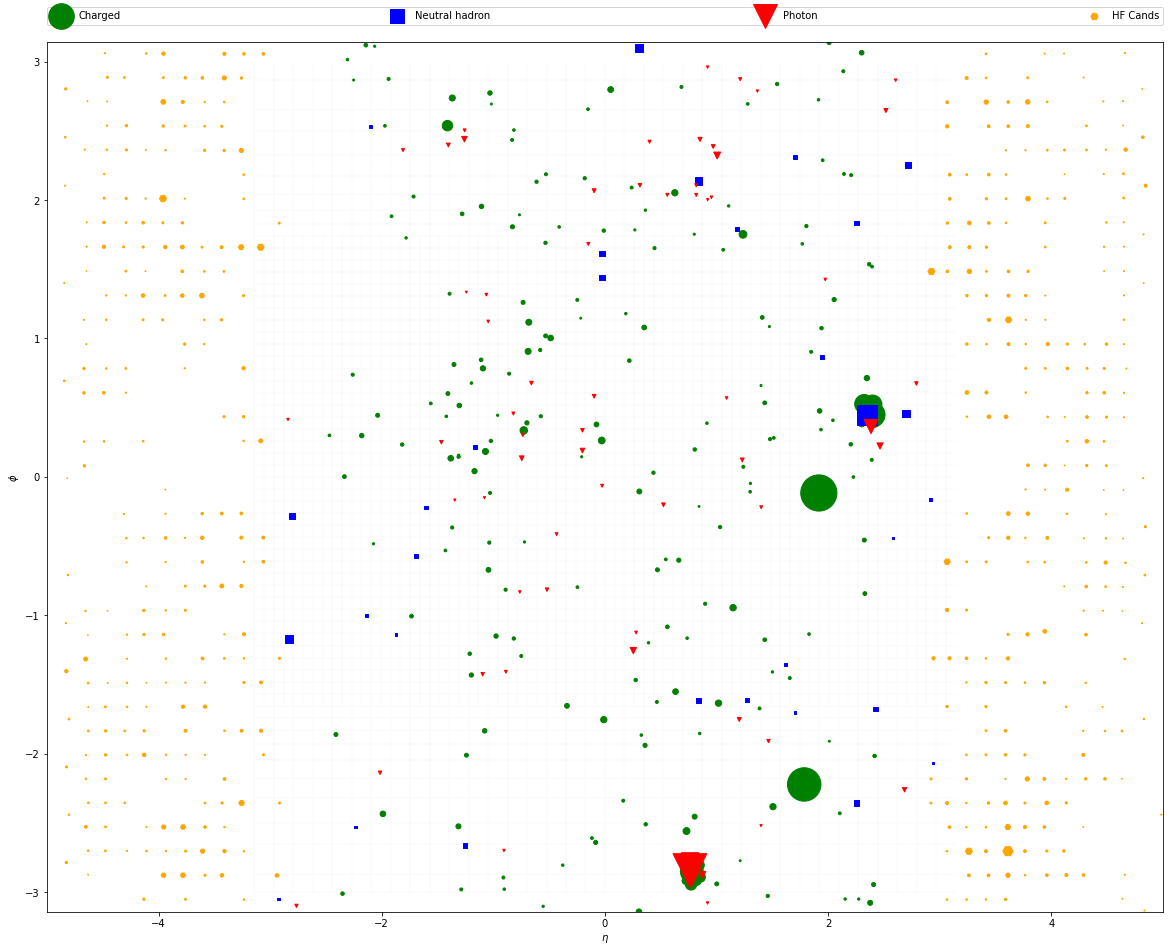

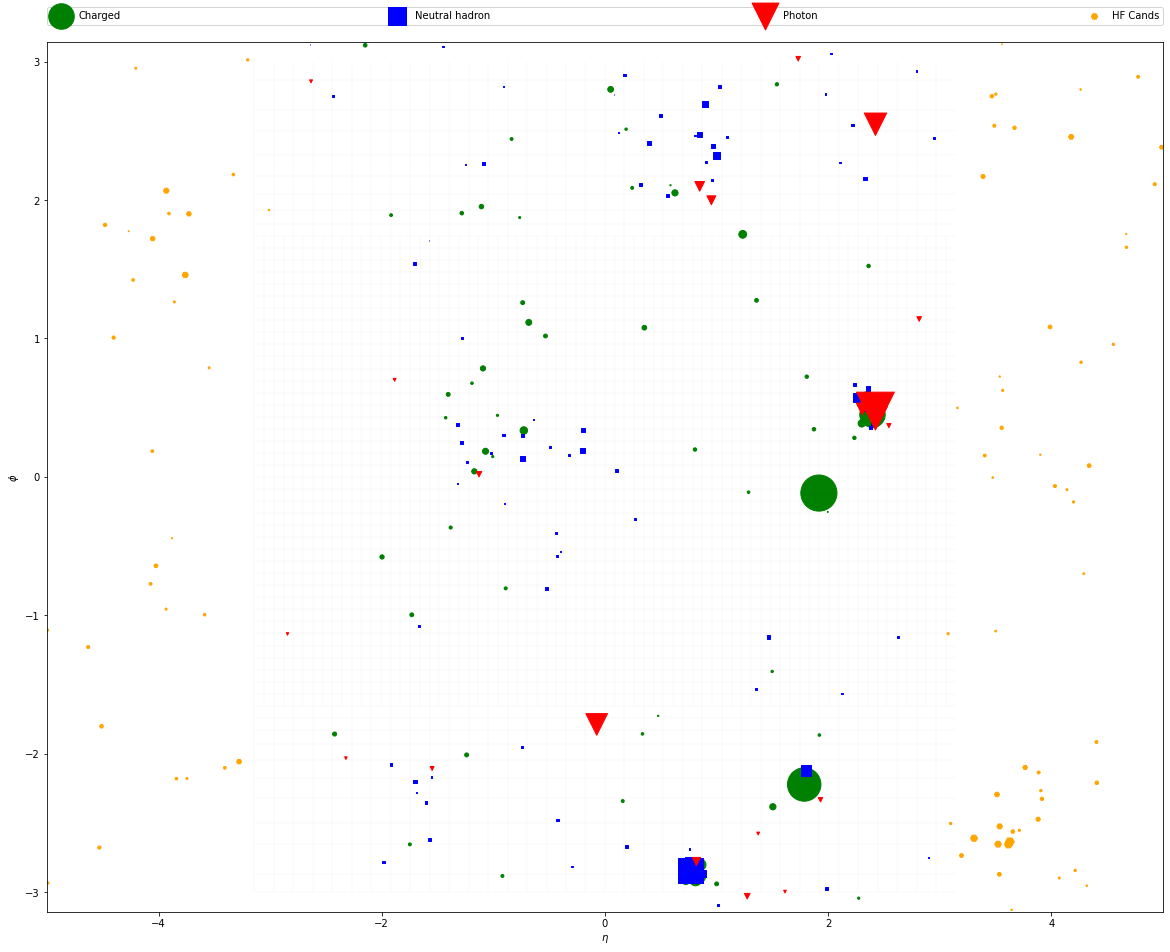

In [7]:
ievt = 3
fig=plt.figure(figsize=(20,16))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(pfcands['PF_eta'][ispfChg][ievt],  pfcands['PF_phi'][ispfChg][ievt],  s=pfcands['PF_pt'][ispfChg][ievt]*20.0,   c='green', label='Charged')
ax.scatter(pfcands['PF_eta'][ispfNeuH][ievt], pfcands['PF_phi'][ispfNeuH][ievt], s=pfcands['PF_pt'][ispfNeuH][ievt]*20.0,  c='blue', marker='s', label='Neutral hadron')
ax.scatter(pfcands['PF_eta'][ispfPho][ievt],  pfcands['PF_phi'][ispfPho][ievt],  s=pfcands['PF_pt'][ispfPho][ievt]*20.0,   c='red',marker='v', label='Photon')
ax.scatter(pfcands['PF_eta'][ispfHF][ievt],   pfcands['PF_phi'][ispfHF][ievt],   s=pfcands['PF_pt'][ispfHF][ievt]*20.0,    c='orange',marker='H', label='HF Cands')
ln_coll = make_line_collection()
ax.add_collection(ln_coll)
ax.set_ylabel(r'$\phi$')
#plt.xticks(np.arange(-np.pi, np.pi))
ax.set_ylim(-np.pi, np.pi)
ax.set_xlabel(r'$\eta$')
ax.set_xlim(-5.0, 5.0)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0.)
#plt.yticks(np.arange(-3.0, 3.0))
plt.show()

fig=plt.figure(figsize=(20,16))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(genparts['packedGenPart_eta'][isgenChg][ievt],  genparts['packedGenPart_phi'][isgenChg][ievt],   s=genparts['packedGenPart_pt'][isgenChg][ievt]*20.0,  c='green', label='Charged')
ax.scatter(genparts['packedGenPart_eta'][isgenPho][ievt],  genparts['packedGenPart_phi'][isgenPho][ievt],   s=genparts['packedGenPart_pt'][isgenPho][ievt]*20.0,  c='blue', marker='s', label='Neutral hadron')
ax.scatter(genparts['packedGenPart_eta'][isgenNeuH][ievt], genparts['packedGenPart_phi'][isgenNeuH][ievt],  s=genparts['packedGenPart_pt'][isgenNeuH][ievt]*20.0, c='red',marker='v', label='Photon')
ax.scatter(genparts['packedGenPart_eta'][isgenHF][ievt],   genparts['packedGenPart_phi'][isgenHF][ievt],    s=genparts['packedGenPart_pt'][isgenHF][ievt]*20.0,   c='orange',marker='H', label='HF Cands')
ln_coll = make_line_collection()
ax.add_collection(ln_coll)
ax.set_ylabel(r'$\phi$')
#plt.xticks(np.arange(-np.pi, np.pi))
ax.set_ylim(-np.pi, np.pi)
ax.set_xlabel(r'$\eta$')
ax.set_xlim(-5.0, 5.0)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',ncol=4, mode="expand", borderaxespad=0.)
#plt.yticks(np.arange(-3.0, 3.0))
plt.show()
#plt.savefig("%s/PF/testPF_%05d.pdf"%(outDir,EVE))